<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Script-setup" data-toc-modified-id="Script-setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Script setup</a></span></li><li><span><a href="#Data-directory-preparention" data-toc-modified-id="Data-directory-preparention-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data directory preparention</a></span></li><li><span><a href="#Data-file-preperation" data-toc-modified-id="Data-file-preperation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data file preperation</a></span><ul class="toc-item"><li><span><a href="#input-directory-(all-general-raw-data-files)" data-toc-modified-id="input-directory-(all-general-raw-data-files)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span><code>input</code> directory (all general raw data files)</a></span></li><li><span><a href="#processed-directory-(all-data-files-produced-in-this-repository)" data-toc-modified-id="processed-directory-(all-data-files-produced-in-this-repository)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span><code>processed</code> directory (all data files produced in this repository)</a></span></li></ul></li><li><span><a href="#Load-data-functions" data-toc-modified-id="Load-data-functions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load data functions</a></span></li><li><span><a href="#Load-data-sets" data-toc-modified-id="Load-data-sets-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Load data sets</a></span></li><li><span><a href="#ENTSO-E-generation-per-technology-CI" data-toc-modified-id="ENTSO-E-generation-per-technology-CI-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>ENTSO-E generation per technology CI</a></span><ul class="toc-item"><li><span><a href="#EF-preparation" data-toc-modified-id="EF-preparation-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>EF preparation</a></span></li><li><span><a href="#Emission-calculation" data-toc-modified-id="Emission-calculation-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Emission calculation</a></span></li></ul></li><li><span><a href="#Compair-ENTSO-E-scaled-vs.-no-scaled" data-toc-modified-id="Compair-ENTSO-E-scaled-vs.-no-scaled-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Compair ENTSO-E scaled vs. no scaled</a></span></li><li><span><a href="#Compair-Bottom-Up-and-Top-down" data-toc-modified-id="Compair-Bottom-Up-and-Top-down-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Compair Bottom Up and Top down</a></span></li><li><span><a href="#Export-results" data-toc-modified-id="Export-results-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Export results</a></span></li></ul></div>

# Introduction

# Script setup

In [1]:
import os
import logging

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from IPython.display import Image 
import datetime
from matplotlib.lines import Line2D

#GEO
import geopandas as gpd

%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 6]

#helpers
from helpers import change_ENTSOE_ProductionTypeName

# Data directory preparention

Create input, processed and output folders if they don't exist
If the paths are relative, the corresponding folders will be created inside the current working directory.
- input -> all needed input data
- processed -> save point and exchange with other scripts
- output -> final emission factors

In [2]:
input_directory_path = os.path.join('input')
processed_directory_path = 'processed'
output_directory_path = os.path.join('output')

os.makedirs(input_directory_path, exist_ok=True)
os.makedirs(processed_directory_path, exist_ok=True)
os.makedirs(output_directory_path, exist_ok=True)

# Data file preperation

## `input` directory (all general raw data files)

- 1) ENTSO-E production per type

Production per type from ENTSO-E
Original data: ENTSO-E Transparency Platform, Actual Generation per Production Type Available online: 
https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show
Processed with the following two script that converts the data to hourly resolution and scale the data to reported yearly data:

- https://github.com/JanFrederickUnnewehr/time_series/tree/generation_per_type
- https://github.com/INATECH-CIG/entso-e_GenerationOutputPerType

File - > entso_gen_type_hourly_table_scaled.csv -> generation per technology


- 2) ENTSO-E production per unit

Production per Unit from ENTSO-E
Original data: ENTSO-E Transparency Platform, Actual Generation per Generation Unit Available online: https://transparency.entsoe.eu/generation/r2/actualGenerationPerGenerationUnit/show (accessed on Apr 29, 2020).
Processed with the following script that converts the data to hourly resolution:

- https://github.com/INATECH-CIG/entso-e_GenerationOutputPerUnit

File - > gen_data.csv -> hourly generation data per unit

File - > unit_data.csv -> information about the generation units



In [3]:
# Checks if the the input directories are empty or not
# Checks all filenames in the input directory

if not os.listdir(input_directory_path) :
    print("The directory for the bootom up method is empty. Please provide the data to the directory as described in the instructions above.")


filenames = [os.path.join(input_directory_path, fn) for fn in os.listdir(input_directory_path)]

print(filenames)

['input\\Bootom_up_methode', 'input\\CO2_Signal', 'input\\ember_EF.csv', 'input\\entso.csv', 'input\\entsoe-statistical-factsheet-2018-stacked.csv', 'input\\entsoe_gen_type_hourly_table.csv', 'input\\entsoe_gen_type_hourly_table_scaled.csv', 'input\\entso_scaled.csv', 'input\\gen_data_2015.csv', 'input\\gen_data_2016.csv', 'input\\gen_data_2017.csv', 'input\\gen_data_2018.csv', 'input\\Matching', 'input\\MDV_table.csv', 'input\\time_series_60min_multiindex.csv', 'input\\top_down_methode', 'input\\unit_data_2015.csv', 'input\\unit_data_2016.csv', 'input\\unit_data_2017.csv', 'input\\unit_data_2018.csv']


## `processed` directory (all data files produced in this repository)

- 1) EF per type and county

File - > EF_bottom_up_methode.csv

- 2) EF per unit

File -> generation_unit_EF_bottom_up_methode.csv

In [4]:
# Checks if the the input directories are empty or not
# Checks all filenames in the input directory

if not os.listdir(processed_directory_path) :
    print("The directory for the CO2 Signal is empty. Please provide the data to the directory as described in the instructions above.")


filenames = [os.path.join(processed_directory_path, fn) for fn in os.listdir(processed_directory_path)]

print(filenames)

['processed\\CI_0_top_down.csv', 'processed\\CI_1_top_down.csv', 'processed\\CI_bottom_up_methode.csv', 'processed\\CI_MAP_1_top_down.csv', 'processed\\EF_bottom_up_methode.csv', 'processed\\generation_unit_EF_bottom_up_methode.csv']


# Load data functions

In [5]:
def load_generation_per_unit(path, fn):
    """
    Load the ENTSO-E gernation per unit data.
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    generation = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=0,parse_dates=True)
    
    return generation

def load_unit_CO2_data(path, fn):
    """
    Own generation unit information with CO2 information per unit
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    df = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=0)

    return df

def load_EF(path, fn):
    """
    Own generated EF per tech and country
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    df = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=[0,1])
    
    return df

def load_timeseries_ENTSOE(path, fn):
    """
    Read generation data from time-series package own modification.


    Parameters
    ----------
    path : TYPE
        DESCRIPTION.
    fn : TYPE
        DESCRIPTION.

    Returns
    -------
    generation : TYPE
        DESCRIPTION.

    """
   
    generation = (pd.read_csv(os.path.join(path, fn), index_col=[0], header=[0, 1], parse_dates=True)
                    .dropna(how="all", axis=0))
       
    
    return generation

# Load data sets

#### Load ENTSO-E generation per type

In [6]:
entsoe_gen_type_org = load_timeseries_ENTSOE(input_directory_path, 'entsoe_gen_type_hourly_table.csv')

#### Load ENTSO-E generation per type scaled with Factsheet

In [7]:
entsoe_gen_type_scal = load_timeseries_ENTSOE(input_directory_path, 'entsoe_gen_type_hourly_table_scaled.csv')

#### Load EF per technology

In [8]:
EF = load_EF(processed_directory_path, 'EF_bottom_up_methode.csv')

# ENTSO-E generation per technology CI

In this section we using the country specific EF for generating the CI for all EU countries. The production data are based on the production per type data from ENTSO-E

## EF preparation 

Since we could not calculate EF for all countries and technologies, we use a stepwise process to close this gap. For all countries where EF is missing, which we calculate in other countries, we average all calculated technology specific EF. Then, we define standard EFs for the technologies where EFs could not be calculated. 

In [9]:
# check EF dataset
EF.head(5)

EF Verified_EF  Coverage  \
MapCode ProductionTypeName                                   
AT      gas                 0.288711        True      68.0   
        hard_coal           0.884070        True      39.0   
BE      gas                 0.389641        True      64.0   
CZ      hard_coal           0.985546        True      36.0   
        lignite             0.928296        True      58.0   

                            EF_round_in_gCO2_kwh  
MapCode ProductionTypeName                        
AT      gas                               288.71  
        hard_coal                         884.07  
BE      gas                               389.64  
CZ      hard_coal                         985.55  
        lignite                           928.30

#### Mean EF from calculated EF

In [10]:
EF_mean = EF.groupby('ProductionTypeName').mean()

# Using a mean EF for other fossils of 0.75 because we only cover some countries with other fossils
# and the resulting mean EF would be above 1.0, which seems too high.
EF_mean.loc['other_fossil'] = 0.75
# converting EF_mean to a diconary
EF_mean = EF_mean.EF.to_dict()

#show resulting EF
print(EF_mean)

{'gas': 0.3665166624413151, 'hard_coal': 0.9088482292089693, 'lignite': 1.180877690651492, 'other_fossil': 0.75}


#### Standard EF per technology

In [11]:
# If no country-specific EFs are available and also no mean EF is available for a country and technology,
# we use the following standard EFs. In addition, we define for the renewable generation types a EF with
# an emission value of 0.
# Source: 

EF_default = {'biomass':0,
              'geothermal':0,
              'hydro':0,
              'nuclear':0,
              'other_renewable':0,
              'solar':0,
              'waste':0.5,
              'wind_offshore':0,
              'wind_onshore':0,
              'marine':0}

#### Multi EF for each country and technology

In [12]:
# Create a dataframe with the EF for each country and technology. If no specific EF is available, we use the default EF.
EF_multi = {}

for i in entsoe_gen_type_scal.columns:
    if i in EF.index:
        print(str(i)+' EF')
        EF_multi[i] = EF.loc[i[0],i[1]].loc['EF']
    elif i[1] in EF_mean:
        print(str(i) +' EF_mean')
        EF_multi[i] = EF_mean[i[1]]
    else:
        print(str(i) + ' EF_default')
        EF_multi[i] = EF_default[i[1]]

('AT', 'biomass') EF_default
('AT', 'gas') EF
('AT', 'hard_coal') EF
('AT', 'hydro') EF_default
('AT', 'other_fossil') EF_mean
('AT', 'other_renewable') EF_default
('AT', 'solar') EF_default
('AT', 'waste') EF_default
('AT', 'wind_onshore') EF_default
('BE', 'biomass') EF_default
('BE', 'gas') EF
('BE', 'hydro') EF_default
('BE', 'nuclear') EF_default
('BE', 'other_fossil') EF_mean
('BE', 'solar') EF_default
('BE', 'waste') EF_default
('BE', 'wind_offshore') EF_default
('BE', 'wind_onshore') EF_default
('BG', 'biomass') EF_default
('BG', 'gas') EF_mean
('BG', 'hard_coal') EF_mean
('BG', 'hydro') EF_default
('BG', 'lignite') EF_mean
('BG', 'nuclear') EF_default
('BG', 'solar') EF_default
('BG', 'waste') EF_default
('BG', 'wind_onshore') EF_default
('CH', 'hydro') EF_default
('CH', 'nuclear') EF_default
('CH', 'solar') EF_default
('CH', 'wind_onshore') EF_default
('CY', 'other_fossil') EF_mean
('CY', 'wind_onshore') EF_default
('CZ', 'biomass') EF_default
('CZ', 'gas') EF_mean
('CZ', 'ha

## Emission calculation

In [13]:
# calculate emissions based on EF and generation per type
CO2_emission_type_org = entsoe_gen_type_org * EF_multi

CO2_emission_type_scal = entsoe_gen_type_scal * EF_multi

#### Total emissions and generation

In [14]:
# Emission in gCO2
CO2_emission_org = (CO2_emission_type_org * 1000000).groupby(level=0, axis=1).sum()
# generation in kWh
Generation_org = (entsoe_gen_type_org * 1000).groupby(level=0, axis=1).sum()

# Emission in gCO2
CO2_emission_scal = (CO2_emission_type_scal * 1000000).groupby(level=0, axis=1).sum()
# generation in kWh
Generation_scale = (entsoe_gen_type_scal * 1000).groupby(level=0, axis=1).sum()

#### Carbon intensity of gernation 

In [15]:
# CI in g CO2/kWh
Carbon_intensitiy_org = CO2_emission_org.div(Generation_org)
# CI in g CO2/kWh
Carbon_intensitiy_scal = CO2_emission_scal.div(Generation_scale)

In [16]:
# mean CI in gCO2/kWh
mean_Carbon_intensitiy_org = CO2_emission_org.sum() / Generation_org.sum()
# mean CI in gCO2/kWh
mean_Carbon_intensitiy_scale = CO2_emission_scal.sum() / Generation_scale.sum()

In [17]:
# transfer mean CI to hourly data set
#Carbon_intensitiy_entsoe_gen_type_mean = Carbon_intensitiy_entsoe_gen_type.copy()
#for i in Carbon_intensitiy_entsoe_gen_type_mean.columns:
#    Carbon_intensitiy_entsoe_gen_type_mean[i] = mean_Carbon_intensitiy_entsoe_gen_type[i]

# Compair ENTSO-E scaled vs. no scaled 

Forming an indicator for emissions and carbon intensity to see how they change by scaling.

#### Emissions

In [18]:
indicator_EM = ((CO2_emission_scal.sum() - CO2_emission_org.sum()) / CO2_emission_scal.sum()).to_frame().fillna(0)

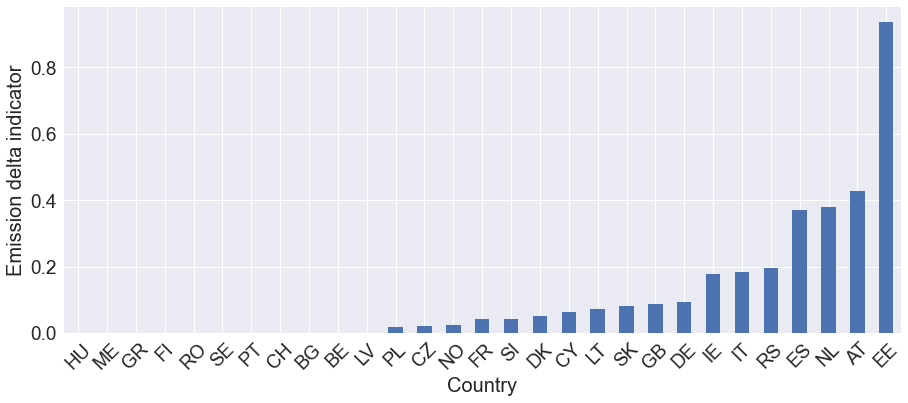

In [19]:
fig, ax = plt.subplots(1, 1)

indicator_EM.sort_values(by=0).plot(kind='bar', ylabel='Emission delta indicator', legend=False, ax=ax)

ax.set_xlabel("Country" , fontsize=20)
ax.set_ylabel("Emission delta indicator", fontsize=20)

ax.tick_params(axis='y',labelsize=19)
ax.tick_params(axis='x',labelsize=19)

ax.tick_params(axis='x', rotation=45)

In [20]:
fig.savefig(os.path.join(output_directory_path + '/_emission_delta_indicator.png'))

#### Carbon intensity

In [21]:
indicator_CI = ((mean_Carbon_intensitiy_scale - mean_Carbon_intensitiy_org) / mean_Carbon_intensitiy_scale).to_frame().fillna(0)

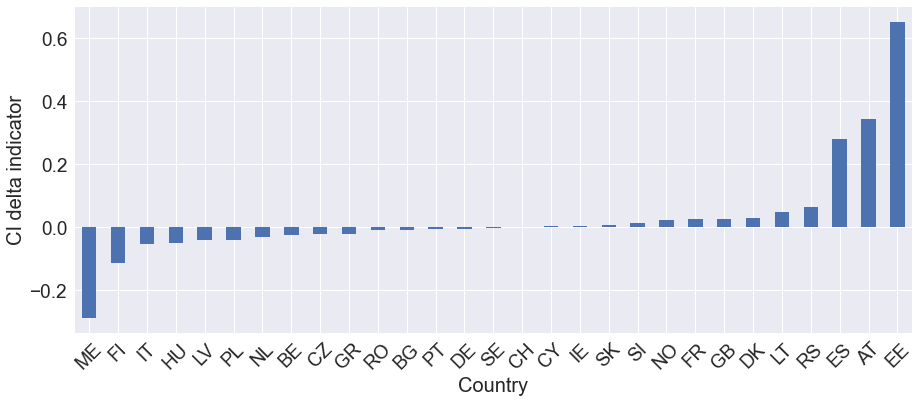

In [22]:
fig, ax = plt.subplots(1, 1)

indicator_CI.sort_values(by=0).plot(kind='bar', ylabel='CI delta indicator', legend=False, ax=ax)

ax.set_xlabel("Country" , fontsize=20)
ax.set_ylabel("CI delta indicator", fontsize=20)

ax.tick_params(axis='y',labelsize=19)
ax.tick_params(axis='x',labelsize=19)

ax.tick_params(axis='x', rotation=45)

In [23]:
fig.savefig(os.path.join(output_directory_path + '/_CI_delta_indicator.png'))

In [24]:
Indicator_compar = pd.DataFrame()
Indicator_compar.index.rename('country',inplace=True)



In [25]:
Indicator_compar['emission_delta_indicator'] = indicator_EM.squeeze()
Indicator_compar['CI_delta_indicator'] = indicator_CI.squeeze()
Indicator_compar['CI_delta_indicator_abs'] = abs(indicator_CI.squeeze())

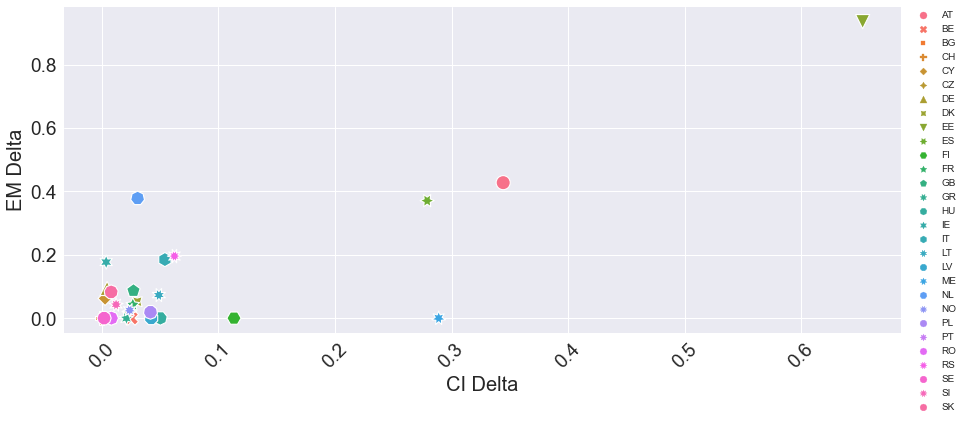

In [26]:
fig, ax = plt.subplots(1, 1)

ax = sns.scatterplot(data=Indicator_compar, x="CI_delta_indicator_abs", y="emission_delta_indicator", hue=Indicator_compar.index, s=200, style=Indicator_compar.index)
#CI_compar.plot(kind='scatter', x="indikator_CI", y="indikator_em", ax=ax, alpha=0.6, s=10, edgecolor='black')

ax.set_xlabel("CI Delta" , fontsize=20)
ax.set_ylabel("EM Delta", fontsize=20)

ax.tick_params(axis='y',labelsize=19)
ax.tick_params(axis='x',labelsize=19)

ax.tick_params(axis='x', rotation=45)

ax.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)

#CI_compar.plot(x='indikator_CI',y='indikator_em',kind='scatter',legend=True)

In [27]:
fig.savefig(os.path.join(output_directory_path + '/_scaling_indicator.png'))

# Compair Bottom Up and Top down

#### Load CI from top down method

In [28]:
CI_top_down = pd.read_csv(os.path.join(processed_directory_path,'CI_1_top_down.csv'), index_col=0)

In [29]:
# set up a dataframe and store CI
CI_compar = pd.DataFrame()
CI_compar.index.rename('country',inplace=True)

CI_compar['CI_top_down'] = CI_top_down.loc[2018].filter(mean_Carbon_intensitiy_scale.index.to_list())

In [30]:
CI_compar['CI_bottom_up'] = mean_Carbon_intensitiy_scale.filter(CI_compar.index.to_list())

CI_compar['diff_bottom_up_vs_CI_top_down'] = CI_compar['CI_bottom_up'] - CI_compar['CI_top_down']
CI_compar['diff_pro'] = round((100 / CI_compar['CI_bottom_up']) * CI_compar['diff_bottom_up_vs_CI_top_down'])

In [31]:
round(CI_compar, 2).sort_values(by='diff_pro', ascending=False)

,CI_top_down,CI_bottom_up,diff_bottom_up_vs_CI_top_down,diff_pro
country,,,,
SE,13.29,40.90,27.60,67.0
LT,60.45,122.42,61.97,51.0
LV,148.24,221.80,73.56,33.0
SK,144.24,208.56,64.33,31.0
IT,262.45,378.11,115.66,31.0
SI,260.85,338.70,77.84,23.0
FI,115.63,145.95,30.32,21.0
HU,265.61,313.95,48.33,15.0
DK,200.42,234.35,33.92,14.0


# Export results 

In [32]:
round(CI_compar, 2).sort_values(by='CI_top_down', ascending=True).to_csv(output_directory_path + '/CI_table.csv')